In [1]:
from halotools.sim_manager import HaloTableCache
from halotools.sim_manager import CachedHaloCatalog
from halotools_ia.correlation_functions import ed_3d, ee_3d
from halotools.utils import rotate_vector_collection

from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Leauthaud11Cens, Leauthaud11Sats, SubhaloPhaseSpace
from halotools_ia.ia_models.ia_model_components import CentralAlignment, RadialSatelliteAlignment
from halotools_ia.ia_models.ia_strength_models import RadialSatelliteAlignmentStrength

from halotools.utils.vector_utilities import (elementwise_dot, elementwise_norm, normalized_vectors,
                                              angles_between_list_of_vectors, vectors_normal_to_planes)

from ellipsoidal_nfw import random_nfw_ellipsoid

from halotools.utils import crossmatch

import numpy as np
import matplotlib.pyplot as plt

# This is not installed!!! Right now, these files are just sitting in the same directory
import inertia_tensors as itens

from generated_halo_helpers import downsample_halo, calculate_axes, separate_axes, get_angles, theta_phi, \
                                    get_rotation_matrix, extract_halo_properties, rotate_halos, generate_matching_halos, \
                                    mask_bad_halocat, get_halo_center

import warnings
warnings.filterwarnings("ignore")

In [2]:
cache = HaloTableCache()
for entry in cache.log: print(entry)

#halocat = CachedHaloCatalog(simname='multidark', redshift=0)
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')
mask_bad_halocat(halocat)

('bolplanck', 'rockstar', 'halotools_v0p4', '-0.0023', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolplanck\rockstar\hlist_1.00231.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolshoi\rockstar\hlist_1.00035.list.halotools_v0p4.hdf5')


In [3]:
# Create model to generate subsample of halos

cens_occ_model = Leauthaud11Cens
cens_prof_model = TrivialPhaseSpace
cens_orientation = CentralAlignment
sats_occ_model = Leauthaud11Sats
sats_prof_model1 = SubhaloPhaseSpace
prof_args1 = ("satellites", np.logspace(10.5, 15.2, 15))
sats_orientation = RadialSatelliteAlignment
sats_strength = RadialSatelliteAlignmentStrength()
Lbox = halocat.Lbox
sats_strength.inherit_halocat_properties(Lbox=Lbox)

model_instance = HodModelFactory(centrals_occupation = cens_occ_model(),
                                 centrals_profile = cens_prof_model(),
                                 satellites_occupation = sats_occ_model(),
                                 satellites_profile = SubhaloPhaseSpace(*prof_args1),
                                 satellites_radial_alignment_strength = sats_strength,
                                 centrals_orientation = cens_orientation(alignment_strength=1),
                                 satellites_orientation = sats_orientation(satellite_alignment_strength=1),
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'satellites_radial_alignment_strength',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )
model_instance.populate_mock(halocat)

# Get the subsample of the halocat of the halos included in the model
hids = model_instance.mock.galaxy_table['halo_id']
inds1, inds2 = crossmatch(hids, halocat.halo_table['halo_id'])
subset = halocat.halo_table[inds2]

subset = subset[:int(len(subset)/3)]

In [4]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [5]:
runs = 100
resolution = 100
batch_size = 10000    # The inertia tensor can only handle calculating so many halos at once

# Get the halo coords for ee and ed since they will never change
halo_coords = np.vstack((subset['halo_x'],
                            subset['halo_y'],
                            subset['halo_z'])).T

# Get the halo orientations to check the delta theta later
halo_orientations = np.vstack((subset['halo_axisA_x'],
                                subset['halo_axisA_y'],
                                subset['halo_axisA_z'])).T

thetas = []
omegas = []
etas = []

for i in range(runs):
    print(i)
    # Generate halos using the properties in the subset
    props = extract_halo_properties(subset)
    halos = generate_matching_halos(props, resolution=resolution, rotate=True)
    
    ind = 0
    axes = []
    # Because the inertia tensor calculation can't handle too many at once, do it in batches and reuse the containers
    while ind < len(subset):
        lengths, evecs = separate_axes( calculate_axes(halos[ind:ind+batch_size]) )
        axes.append( evecs[:,:,0] )
        ind += batch_size
    
    # Stack the axes together into one array now and calculate the desired quantities
    axes = np.vstack( axes )
    thetas.append( angles_between_list_of_vectors( halo_orientations, axes ) )
    omegas.append( ed_3d(halo_coords, axes, halo_coords, rbins, period=halocat.Lbox) )
    etas.append( ee_3d(halo_coords, axes, halo_coords, axes, rbins, period=halocat.Lbox) )

# By the end of this loop, the folowing variables have the following shapes:
# angles - (runs, len(subsample) )
#    - Each list item is a list of all the angles between the generated axis and the halo axis they were modeled from
# omegas - (runs, rbins)
#    - Each list item is the result of ed_3d for that run, with a length equeal to rbins
# etas - (runs, rbins)
#    - same as omega

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
flat_angles = np.hstack(thetas)
flat_angles = np.minimum(flat_angles, np.pi-flat_angles)

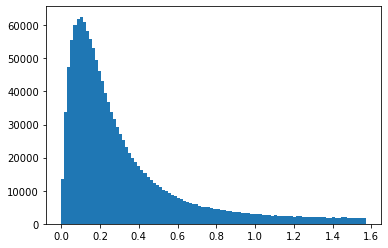

In [11]:
plt.hist(flat_angles,bins=100);

In [16]:
np.save("etas.npy",etas)

In [17]:
etas = np.load("Results\etas.npy")